# Sequence-to-Sequence Modeling with nn.Transformer and TorchText

# Building A Tranformer

## nn.Transformer

This is a tutorial on how to train a sequence-to-sequence model that uses the nn.Transformer module.

PyTorch 1.2 release includes a standard transformer module based on the paper Attention is All You Need. 

The transformer model has been proved to be superior in quality for many sequence-to-sequence problems while being more parallelizable. 

The nn.Transformer module relies entirely on an attention mechanism (another module recently implemented as nn.MultiheadAttention) to draw global dependencies between input and output. The nn.Transformer module is now highly modularized such that a single component (like nn.TransformerEncoder in this tutorial) can be easily adapted/composed.

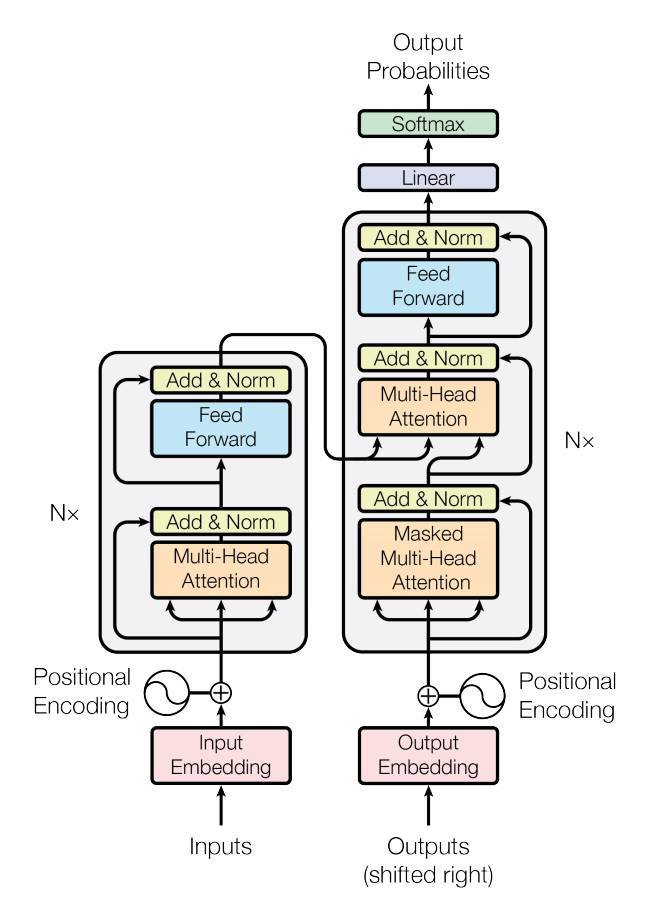

## Build a transformer

In this tutorial, we train nn.TransformerEncoder model on a language modeling task. The language modeling task is to assign a probability for the likelihood of a given word (or a sequence of words) to follow a sequence of words. 

A sequence of tokens are passed to the embedding layer first, followed by a positional encoding layer to account for the order of the word (see the next paragraph for more details). 

The nn.TransformerEncoder consists of multiple layers of nn.TransformerEncoderLayer. Along with the input sequence, a square attention mask is required because the self-attention layers in nn.TransformerEncoder are only allowed to attend the earlier positions in the sequence. 

For the language modeling task, any tokens on the future positions should be masked. To have the actual words, the output of nn.TransformerEncoder model is sent to the final Linear layer, which is followed by a log-Softmax function.

In [0]:
import math
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [0]:
class TransformerModel(nn.Module):
    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super().__init__()
        self.model_type = "Tranformer"
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layer = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layer, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)
    
    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask
        
        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        out = self.transformer_encoder(src, self.src_mask)
        out = self.decoder(out)
        return out



PositionalEncoding module injects some information about the relative or absolute position of the tokens in the sequence. 

The positional encodings have the same dimension as the embeddings so that the two can be summed. Here, we use sine and cosine functions of different frequencies.

In [0]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# Load and batch data

The training process uses Wikitext-2 dataset from torchtext. 

The vocab object is built based on the train dataset and is used to numericalize tokens into tensors. 

Starting from sequential data, the batchify() function arranges the dataset into columns, trimming off any tokens remaining after the data has been divided into batches of size batch_size. 

For instance, with the alphabet as the sequence (total length of 26) and a batch size of 4, we would divide the alphabet into 4 sequences of length 6:

In [0]:
import torchtext
from torchtext.data.utils import get_tokenizer

In [0]:
TEXT = torchtext.data.Field(tokenize=get_tokenizer("spacy"),
                            init_token='<sos>',
                            eos_token='<eos>',
                            lower=True)

In [0]:
train_txt, val_txt, test_txt = torchtext.datasets.WikiText2.splits(TEXT)

In [0]:
TEXT.build_vocab(train_txt)

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
def batchify(data, bsz):
    data = TEXT.numericalize([data.examples[0].text])
    # Divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

In [0]:
batch_size = 20
eval_batch_size = 10
train_data = batchify(train_txt, batch_size)
val_data = batchify(val_txt, eval_batch_size)
test_data = batchify(test_txt, eval_batch_size)

In [48]:
!nvidia-smi

Tue May  5 20:09:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    33W /  70W |    901MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Functions to generate input and target sequence

get_batch() function generates the input and target sequence for the transformer model. It subdivides the source data into chunks of length bptt. For the language modeling task, the model needs the following words as Target. For example, with a bptt value of 2, we’d get the following two Variables for i = 0:

It should be noted that the chunks are along dimension 0, consistent with the S dimension in the Transformer model. The batch dimension N is along dimension 1.

In [0]:
bptt = 35
def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target

# Create Model

In [0]:
ntokens = len(TEXT.vocab.stoi) # the size of vocabulary
emsize = 200 # embedding dimension
nhid = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

# Run the model

CrossEntropyLoss is applied to track the loss and SGD implements stochastic gradient descent method as the optimizer. 

The initial learning rate is set to 5.0. StepLR is applied to adjust the learn rate through epochs. During the training, we use nn.utils.clip_grad_norm_ function to scale all the gradient together to prevent exploding.

In [0]:
criterion = nn.CrossEntropyLoss()
lr = 5.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

In [0]:
def train():
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    ntokens = len(TEXT.vocab.stoi)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = 200
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // bptt, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    ntokens = len(TEXT.vocab.stoi)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            output = eval_model(data)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
    return total_loss / (len(data_source) - 1)

Loop over epochs. Save the model if the validation loss is the best we’ve seen so far. Adjust the learning rate after each epoch.

In [0]:
best_val_loss = float("inf")
epochs = 3 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train()
    val_loss = evaluate(model, val_data)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()